# Semantic Categorization Data Manipulation

In [822]:
import sys
import os
import string
import json
import math
import random
from random import random
from random import randint
import argparse
import re
import matplotlib.pyplot as plt
import timeit
import spacy
import numpy as np
import pickle
from pylab import *
from copy import deepcopy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import tree
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from hashlib import sha256
import urllib.request
from torch.utils.data import Dataset, DataLoader, TensorDataset
dtype_float = torch.FloatTensor
dtype_long = torch.LongTensor

In [107]:
nlp = spacy.load('en', disable = ['parser','ner'])

In [109]:
# import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
wordnet_lemmatizer.lemmatize('encryption')

'encryption'

In [116]:
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
lancaster_stemmer.stem('processing')

'process'

In [147]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
porter_stemmer.stem('callback')

'callback'

- Process data into .txt. 
- Test for reading and writing files.

In [6]:
def extractLine(file_path):
    f = open(file_path, 'r')
    data = f.readlines()
    f.close()
    MessageText = []
    i = 0
    while(i < len(data)):
        if "MessageText" in data[i]:
            MessageText.append(data[i+2].split("// ")[1].strip())
            i += 2
        else:
            i += 1
    return MessageText

In [7]:
def writeFile(data, outputFileName):
    f = open(outputFileName, 'w')
    for line in data:
        f.write(line + '\n')
    f.close()
    
def readFile(FileName):
    f = open(FileName, 'r')
    data = f.read().split('\n')
    f.close()
    return data

In [8]:
file_path = './WinError.h'
data = extractLine(file_path)
print(data[0])

The operation completed successfully.


In [9]:
writeFile(data, 'MessageText.txt')
readData = readFile('MessageText.txt')
print(readData[0])

The operation completed successfully.


## Preprocessing Original Data

In [10]:
def proc(comment, steps=range(1,9)):
    ''' This function pre-processes a single comment

    Parameters:                                                                      
        comment : string, the body of a comment
        steps   : list of ints, each entry in this list 
        corresponds to a preprocessing step  

    Returns:
        modComm : string, the modified comment 
    '''

    #modComm = ''
    if 1 in steps:
        # separate the punctuations from the words except for e.g., i.e., and convert to lower case
        word_list = comment.split(' ')
        comment = ''
        for word in word_list:
            word = word.lower()
            if 'e.g.' in word:
                word = word.replace('e.g.', ' e.g. ').strip()
            elif '%' not in word:
                word = re.sub(r"[\w']+", lambda pat: ' ' + pat.group(0)+' ',
                                  word).strip()
            else:
                pass
            comment += word + ' '
    if 2 in steps:
        # Each token is tagged with its part-of-speech using spaCy
        a = re.compile("[\S]+").findall(comment)
        doc = spacy.tokens.Doc(nlp.vocab,words = a)
        doc = nlp.tagger(doc)
        comment = ''
        for token in doc:
            comment += str(token.text) + '/' + token.tag_ + ' '
            
    if 3 in steps:
        # Remove StopWords(with tags)
        pattern = re.compile(r'\b(' + r'|'.join(StopWords) + r')\b')
        comment = pattern.sub('', comment)
        pattern = re.compile(r"(\B)/[\w]+(?=\s)")
        comment = pattern.sub('', comment)
        # Clear out the spaces
        a = re.compile("[\S]+").findall(comment)
        comment = ''
        for e in a:
            comment += e + ' '
        comment = comment.strip()
        
    if 4 in steps:
        # get rid of the punctuations
        word_list = comment.split(' ')
        comment = ''
        for word in word_list:
            if word in string.punctuation:
                word = ''
            else:
                pass
            comment += word + ' '

    if 5 in steps:
        # remove StopWords(without tags)
        pattern = re.compile(r'\b(' + r'|'.join(StopWords) + r')\b')
        comment = pattern.sub('', comment)
        a = re.compile("[\S]+").findall(comment)
        comment = ''
        for e in a:
            comment += e + ' '
        comment = comment.strip()
        
    if 6 in steps:
        # lemmatization with LancasterStemmer
        word_list = comment.split(' ')
        comment = ''
        for word in word_list:
            word = lancaster_stemmer.stem(word)
            comment += word + ' '
    
    if 7 in steps:
        # lemmatization with WordNetLemmatizer
        word_list = comment.split(' ')
        comment = ''
        for word in word_list:
            word = wordnet_lemmatizer.lemmatize(word)
            comment += word + ' '

    if 8 in steps:
        # lemmatization with PorterStemmer
        word_list = comment.split(' ')
        comment = ''
        for word in word_list:
            word = porter_stemmer.stem(word)
            comment += word + ' '
            
    modComm = comment
    return modComm


In [159]:
def preproc():
    allOutput = []
    file_path = './WinError.h'
    data = extractLine(file_path)
    for line in data:
        pre_text = proc(line, [1,4,5])
        allOutput.append(pre_text)
        writeFile(allOutput, 'noPunctuations.txt')

In [11]:
StopWords_path = 'StopWords.txt'
StopWords = open(StopWords_path, 'r')
StopWords = StopWords.read().split('\n')

In [163]:
preproc()


## Building Vocabulary and Finding Keywords

In [1078]:
def buildVocab(data):
    vocab = {}
    for line in data:
        for word in line:
            if word not in vocab.keys():
                vocab[word] = 1
            else:
                vocab[word] += 1
    return vocab

def itemget(item):
    return item[1]

def mostFreqWord(vocab):
    vocabList =[(key, value) for key,value in vocab.items()]
    rank = sorted(vocabList, key=itemget,reverse=True)
    print([i[0] for i in rank[:50]])
    
def vectorizeData(data):
    Vec = [x.split(' ') for x in data]
    return Vec

Get most frequent words without/with stemmers in order to etraxt keywords for Categorization

In [96]:
data = readFile('noPunctuations.txt')
data = vectorizeData(data)
vocab = buildVocab(data)
mostFreqWord(vocab)
# print(vocab[''])

['not', 'invalid', 'cannot', 'error', 'system', 'file', 'failed', 'object', 'service', 'data', 'no', 'drive', 'server', 'found', 'transaction', 'log', 'request', 'key', 'type', 'domain', 'valid', 'cluster', 'network', 'bitlocker', 'directory', 'policy', 'device', 'supported', 'group', 'disk', 'mode', 'information', 'exist', 'security', 'call', 'certificate', 'user', 'attribute', 'process', 'version', 'occurred', 'unable', 'driver', 'handle', 'can', 'virtual', 'encryption', 'computer', 'exists', 'windows']


In [97]:
data = readFile('noPunctuationsWordNetLemmatizer.txt')
data = vectorizeData(data)
vocab = buildVocab(data)
mostFreqWord(vocab)

['not', 'invalid', 'cannot', 'error', 'system', 'file', 'failed', 'object', 'service', 'drive', 'data', 'no', 'server', 'found', 'transaction', 'log', 'request', 'type', 'key', 'disk', 'domain', 'cluster', 'valid', 'group', 'attribute', 'policy', 'network', 'bitlocker', 'device', 'directory', 'mode', 'supported', 'information', 'user', 'certificate', 'call', 'exist', 'security', 'version', 'process', 'driver', 'handle', 'occurred', 'unable', 'can', 'virtual', 'encryption', 'computer', 'exists', 'support']


In [98]:
data = readFile('noPunctuationsLancasterStemmer.txt')
data = vectorizeData(data)
vocab = buildVocab(data)
mostFreqWord(vocab)

['not', 'invalid', 'serv', 'cannot', 'er', 'fail', 'driv', 'system', 'fil', 'object', 'dat', 'no', 'ex', 'support', 'transact', 'cal', 'mod', 'log', 'found', 'process', 'request', 'valid', 'op', 'typ', 'key', 'direct', 'act', 'disk', 'domain', 'instal', 'reg', 'clust', 'group', 'cert', 'attribut', 'policy', 'network', 'us', 'bitlock', 'dev', 'config', 'encrypt', 'virt', 'inform', 'sec', 'complet', 'handl', 'un', 'man', 'vert']


In [99]:
data = readFile('noPunctuationsPorterStemmer.txt')
data = vectorizeData(data)
vocab = buildVocab(data)
mostFreqWord(vocab)

['not', 'invalid', 'cannot', 'error', 'system', 'file', 'fail', 'object', 'servic', 'drive', 'data', 'no', 'exist', 'support', 'server', 'transact', 'found', 'log', 'request', 'valid', 'call', 'process', 'type', 'key', 'disk', 'domain', 'instal', 'cluster', 'group', 'attribut', 'polici', 'certif', 'network', 'bitlock', 'devic', 'directori', 'configur', 'encrypt', 'virtual', 'mode', 'inform', 'secur', 'complet', 'occur', 'user', 'activ', 'version', 'manag', 'handl', 'provid']


### Categories:
    - success/complet(complete):
    - failure: (38 types)
        system, file, object, servic(service), drive, data, support, server, transact, found(not found), log, call, process, type, key, domain, user, instal(installation), cluster, group, attribut, polici, certif, network, bitlock, devic, directori, configur, encrypt, context, virtual(virtual machine & vertulization), windows('window' is removed, windows system error is kept), mode, inform(information), secur(security), version, connect, provid(provider) -> these are based on PorterStemmer lemmatization
        
* 'group policy' can be a case of digram


### Labeling Message Text with categories

In [652]:
labels = ['success', 'system', 'file', 'object', 'servic', 'drive', 'data', 'support', 'server', 'transact',
          'found', 'log', 'call', 'process', 'type', 'key', 'domain', 'user', 'instal', 'cluster', 'group', 
         'attribut', 'polici', 'certif', 'network', 'bitlock', 'devic', 'directori', 'configur', 'encrypt', 
          'context','virtual', 'mode', 'inform', 'secur', 'windows','version', 'connect']
data = readFile('noPunctuationsPorterStemmer.txt')
def labelData(labels, data):
    '''
        Label data with label, returns a list of Data and a list of Label in corresponded sequence
    '''
    labeled = {}
    Data = []
    Label = []
    for line in data:
        # not labeled
        for label in labels:
            if label in line:
                # TODO: need to mannually consider the 'complet' case here
                if label == 'success' and 'not ' not in line and 'no ' not in line and 'fail' not in line: 
                    labeled[line] = 'success'
                else:
                    labeled[line] = label
    for line in data:
        if line not in labeled.keys():
            labeled[line] = 'other'
            
    for key, val in labeled.items():
        Data.append(key)
        Label.append(val)
    return Data, Label


## Word Embedding

In [1091]:
def get_dataset(new_category, n):
    '''
    input: new_category is a dict that has keys of category number, values are the embedded vectors of the words 
    with the length of 44*50
    '''
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    seed(10)
    for i in range(len(new_category.keys())):
        x = new_category[i]
        y = [i] * n
        seed(190)
        X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(x, y, test_size=0.1, random_state=42)
        X_train += X_train_i
        X_test += X_test_i
        y_train += y_train_i
        y_test += y_test_i

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    return X_train, X_test, y_train, y_test

In [650]:
def getVec(Data):
    dataVec = []
    for key, val in labeledData.items():
        dataVec.append(key.split())
    return dataVec

In [382]:
def save_data(data, name):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_data(name):
    with open(name + '.pickle', 'rb') as handle:
        saved_data = pickle.load(handle)
    return saved_data

In [914]:
def embeddData(dataVec, labels, word2glove, featureLength, start = 0., end = 1.):
    embeddedLength = 50
#     featureLength = max(len(dataVec[i]) for i in range(len(dataVec)))
    embedded = np.empty((0, 44, 50))
    pad = np.zeros(embeddedLength)
    data = list(taggeddata.keys())
    label = list(taggeddata.values())
    for line in data[int(start*len(data)):int(end*len(data))]:
        wordList = []
        for word in line:
            if word in word2glove.keys():
                wordArray = word2glove[word]
                wordList.append(wordArray)
                if len(wordList) == featureLength:
                    break
        numPadding = featureLength - len(wordList)
        for i in range(numPadding):
            wordList.insert(0,pad)
        embedded = np.concatenate((embedded, np.array(wordList).reshape((1, featureLength, embeddedLength))), axis = 0)
        
        if (embedded.shape[0]%1000 == 0):
            print('embedded shape is', embedded.shape)
        
    embedded = np.array(embedded)    
    save_data(embedded, 'embedded')
                              
    return embedded

In [653]:
with open('./glove/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()

    glove_weights = np.zeros((len(lines), 50))
    words = []
    for i, line in enumerate(lines):
        word_weights = line.split()
        words.append(word_weights[0])
        weight = word_weights[1:]
        glove_weights[i] = np.array([float(w) for w in weight])
    word_vocab = [w.decode("utf-8") for w in words]

    word2glove = dict(zip(word_vocab, glove_weights))

## RNN Model

split into training and testing data

In [656]:
class messageDataset(Dataset):
    def __init__(self, data, label):
        self.trainingData = data
        self.trainingLabel = label
        
    def __len__(self):
        return self.trainingData.shape[0]

    def __getitem__(self, idx):
        return self.trainingData[idx,:, :], self.trainingLabel[idx]
    

class LSTMClassifier(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, tagset_size, mini_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.minibatch_size = mini_size
        
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
        self.sigm = nn.Softmax()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, self.minibatch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, self.minibatch_size, self.hidden_dim)))

    def forward(self, sentence):
        lstm_out, self.hidden = self.lstm(sentence, self.hidden)
        tag_scores = self.hidden2tag(lstm_out[-1])
        tag_probs = self.sigm(tag_scores)
        return tag_probs
    

In [655]:
def get_label_num(Labels, label2Idx):
    labelNum = []
    for l in Labels:
        labelNum.append(label2Idx[l])
    return labelNum

def convert_label_to_idx(labels):
    i = 0
    label2Idx = {}
    for key in labels:
        label2Idx[key] = i
        i += 1
    return label2Idx

In [1008]:
def training(X_train, X_test, y_train, y_test, modelName = 'newmodel.pt', embedding_dim = 50, hidden_dim = 100, 
             tagset_size = 38, time_steps  = 36, batch_size = 64, n_epoch = 200):

    model = LSTMClassifier(embedding_dim, hidden_dim, tagset_size, batch_size)
    trainedmodel, result = Model(model, X_train, y_train, X_test, y_test, embedding_dim = embedding_dim, 
                                 hidden_dim = hidden_dim, tagset_size = tagset_size, time_steps = time_steps, 
                                 batch_size = batch_size, n_epoch = n_epoch, modelName = modelName)
    torch.save(trainedmodel, modelName)
    return result
    

In [1109]:
def Model(model, trainingData, trainingLabel, vtrainingData, vtrainingLabel, embedding_dim = 50, hidden_dim = 100,
          tagset_size = 38, time_steps = 36, batch_size = 64, n_epoch = 200, modelName = "trainedmodel.pt"):
    
    dataset = messageDataset(trainingData, trainingLabel)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss = nn.NLLLoss()
    result_list = []
    
    for epoch in range(n_epoch):
        for x,y in dataloader:
            trainx = np.transpose(x, (1, 0, 2))
            trainx = Variable(trainx, requires_grad=False).type(dtype_float)
            trainy = Variable(y, requires_grad=False).type(dtype_long)
            model.zero_grad()
            model.minibatch_size = len(trainy)
            model.hidden = model.init_hidden()
            output = model(trainx)
            err = loss(output, trainy)
            err.backward()
            optimizer.step()
            
        training = accuracy(model, trainingData, trainingLabel)
        testing = accuracy(model, vtrainingData, vtrainingLabel)
        result_list.append([epoch, training, testing])
        print('epoch:', epoch, 'training:', training, 'testing:', testing, end = "\r")
    return model, result_list


In [1103]:
def accuracy(model, trainingData, trainingLabel):
    trainx = np.transpose(trainingData, (1, 0, 2))
    trainx = Variable(torch.from_numpy(trainx), requires_grad=False).type(dtype_float)
    model.minibatch_size = len(trainingLabel)
    model.hidden = model.init_hidden()
    output = model(trainx)
    output_vec = output_reg(output)
    correct = 0
    for i in range(trainingLabel.shape[0]):
        if trainingLabel[i]==output_vec[i]:
            correct += 1
    print('Number of correct label:', correct)
    print('Total number of data:', trainingLabel.shape[0])
    return float(correct)/trainingLabel.shape[0]

### Distribution of Categories:

In [1097]:
def make_n(ls, n):
    seed(50)
    while(len(ls) < n):
        b = len(ls)-1
        new_i = randint(0,b)
        ls.append(ls[new_i])
    return ls

def pick_n(ls, n):
    seed(40)
    new_ls = []
    while(len(new_ls) < n):
        b = len(ls)-1
        new_i = randint(0,b)
        new_ls.append(ls[new_i])
    return new_ls

def prepare_data(category, n):
    seed(2)
    new_category = {}
    for i in range(len(category.keys())):
        if len(category[i]) < n:
            standard_list = make_n(category[i], n)
            new_category[i] = standard_list
        else:
            standard_list = pick_n(category[i], n)
            new_category[i] = standard_list
    
    save_data(new_category, 'category_'+str(n)+'_dict')
    return new_category
    
#  Find the category that has an amount under n sentences
def cat_result(category, n):
    x = range(len(category))
    y = []
    under = []
    for i in range(len(category)):
        if len(category[i]) < n:
            under.append(i)
        y.append(len(category[i]))
    print('label index for amount under n =', under)
    print('amount for each label is =', y)
    
    return x, y, under

def categorization(Data, Labels):
    category = {}
    for i in range(len(Labels)):
        if Labels[i] not in category.keys():
            category[Labels[i]] = [Data[i]]
        else:
            category[Labels[i]].append(Data[i])
    return category

## Entire Process

label index for amount under n = [0, 1, 4, 5, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36]
amount for each label is = [7, 71, 118, 121, 62, 58, 127, 91, 77, 93, 101, 124, 121, 99, 88, 62, 38, 69, 50, 73, 55, 79, 51, 79, 81, 22, 87, 89, 81, 82, 69, 101, 104, 99, 54, 78, 86, 1583]


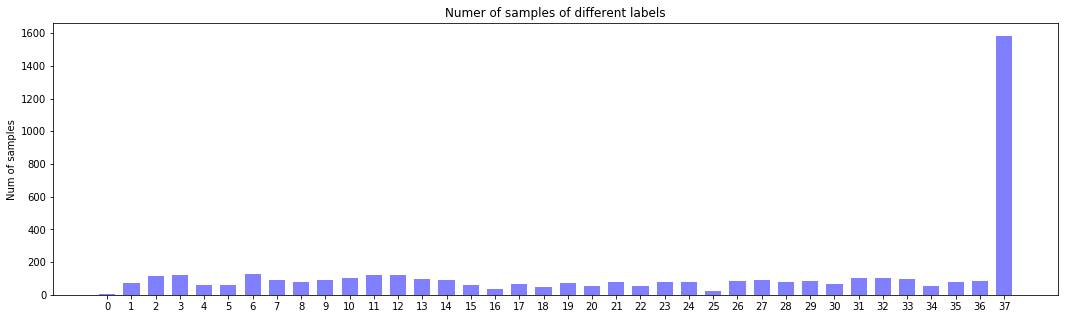

In [1041]:
labels = ['success', 'system', 'file', 'object', 'servic', 'drive', 'data', 'support', 'server', 'transact',
          'found', 'log', 'call', 'process', 'type', 'key', 'domain', 'user', 'instal', 'cluster', 'group', 
         'attribut', 'polici', 'certif', 'network', 'bitlock', 'devic', 'directori', 'configur', 'encrypt', 
          'virtual', 'mode', 'inform', 'secur', 'window','version', 'connect']
# labels.append('other')
# label2Idx = convert_label_to_idx(labels)
label2Idx = {'success': 0, 'system': 1, 'file': 2, 'object': 3, 'servic': 4, 'drive': 5, 'data': 6, 
             'support': 7, 'server': 8, 'transact': 9, 'found': 10, 'log': 11, 'call': 12, 'process': 13, 
             'type': 14, 'key': 15, 'domain': 16, 'user': 17, 'instal': 18, 'cluster': 19, 'group': 20, 
             'attribut': 21, 'polici': 22, 'certif': 23, 'network': 24, 'bitlock': 25, 'devic': 26, 
             'directori': 27, 'configur': 28, 'encrypt': 29, 'virtual': 30, 'mode': 31, 'inform': 32, 
             'secur': 33, 'window': 34, 'version': 35, 'connect': 36, 'other': 37}

# data = readFile('noPunctuationsPorterStemmer.txt')
# # Label data with label, returns a list of Data and a list of Label in corresponded sequence
# Data, Labels = labelData(labels, data)
# dataVec = getVec(Data)
# labelNum = get_label_num(Labels, label2Idx)
# featureLength = 44
# embedded = embeddData(dataVec, labels, word2glove, featureLength, start = 0., end = 1.)

n = 100
category = categorization(embedded, labelNum)
x, y, under = cat_result(category, n)

# Frequency plot
width = 1/1.5
plt.figure(figsize=(18, 5))
plt.bar(x, y, width, color="blue", align='center', alpha=0.5)
# plt.xticks(x, Labels)
plt.xticks(x)
plt.ylabel('Num of samples')
plt.title('Numer of samples of different labels')
fig = plt.show()

### Choosing n=100 as the averge number of training case

label index for amount under n = []
amount for each label is = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


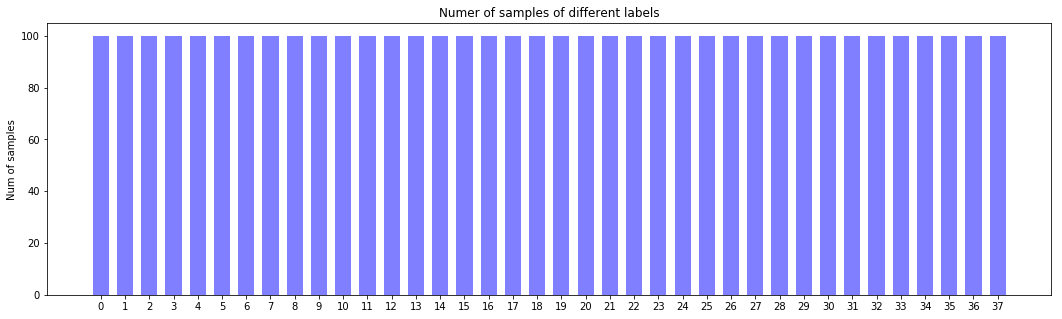

In [1046]:
n = 100
new_category = prepare_data(category, n) 
x, y, under = cat_result(new_category, n)

# Plot Distribution plot
width = 1/1.5
plt.figure(figsize=(18, 5))
plt.bar(x, y, width, color="blue", align='center', alpha=0.5)
# plt.xticks(x, Labels)
plt.xticks(x)
plt.ylabel('Num of samples')
plt.title('Numer of samples of different labels')
plt.show()

# Save Results
# save_data(new_category, 'category_100_dict')


In [1085]:
def output_reg(output):
    output_vec = []
#   [3420, 38]
    for i in range(output.shape[0]):
        m = max(output[i].data)
        for j in range(len(output[i].data)):
            if output[i].data[j] == m:
                output_vec.append(j)
    return output_vec

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Number of correct label: 126
Total number of data: 3420
Number of correct label: 14
Total number of data: 380
Number of correct label: 2290526315789 testing: 0.03684210526315789
Total number of data: 3420
Number of correct label: 20
Total number of data: 380
Number of correct label: 3016432748538 testing: 0.05263157894736842
Total number of data: 3420
Number of correct label: 26
Total number of data: 380
Number of correct label: 4999590643275 testing: 0.06842105263157895
Total number of data: 3420
Number of correct label: 47
Total number of data: 380
Number of correct label: 53732748538 testing: 0.12368421052631579
Total number of data: 3420
Number of correct label: 49
Total number of data: 380
Number of correct label: 561438596491 testing: 0.12894736842105264
Total number of data: 3420
Number of correct label: 58
Total number of data: 380
Number of correct label: 7128771929826 testing: 0.15263157894736842
Total number of data: 3420
Number of correct label: 67
Total number of data: 380

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


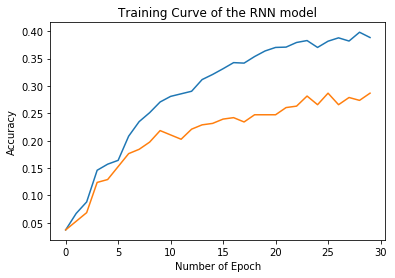

In [1110]:
# new_category = load_data('category_100_dict')
n = 100
seed(22)
X_train, X_test, y_train, y_test = get_dataset(new_category, n)
result = training(X_train, X_test, y_train, y_test, modelName = 'trainedmodel.pt', embedding_dim = 50, 
                  hidden_dim = 200, tagset_size = 38, time_steps = 30, batch_size = 64, n_epoch = 30)

save_data(result, 'result'+str(n))
result = load_data('result'+str(n))

x = [result[i][0] for i in range(len(result))]
train_result = [result[i][1] for i in range(len(result))]
test_result = [result[i][2] for i in range(len(result))]

plt.plot(x,train_result,label='train')
plt.plot(x,test_result,label='test')
plt.title('Training Curve of the RNN model')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epoch')
plt.show()


/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Number of correct label: 219
Total number of data: 3420
Number of correct label: 19
Total number of data: 380
Number of correct label: 3578771929825 testing: 0.05
Total number of data: 3420
Number of correct label: 33
Total number of data: 380
Number of correct label: 5616491228071 testing: 0.0868421052631579
Total number of data: 3420
Number of correct label: 50
Total number of data: 380
Number of correct label: 6378771929826 testing: 0.13157894736842105
Total number of data: 3420
Number of correct label: 55
Total number of data: 380
Number of correct label: 7660994152045 testing: 0.14473684210526316
Total number of data: 3420
Number of correct label: 68
Total number of data: 380
Number of correct label: 849081871345 testing: 0.17894736842105263
Total number of data: 3420
Number of correct label: 75
Total number of data: 380
Number of correct label: 960140350877 testing: 0.19736842105263158
Total number of data: 3420
Number of correct label: 79
Total number of data: 380
Number of corr

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


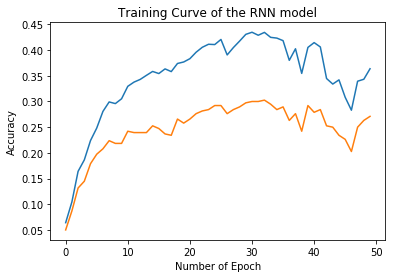

In [1111]:
new_category = load_data('category_100_dict')
n = 100
seed(22)
X_train, X_test, y_train, y_test = get_dataset(new_category, n)
result = training(X_train, X_test, y_train, y_test, modelName = 'trainedmodel.pt', embedding_dim = 50, 
                  hidden_dim = 200, tagset_size = 38, time_steps = 36, batch_size = 64, n_epoch = 50)

save_data(result, 'result'+str(n))
result = load_data('result'+str(n))

x = [result[i][0] for i in range(len(result))]
train_result = [result[i][1] for i in range(len(result))]
test_result = [result[i][2] for i in range(len(result))]

plt.plot(x,train_result,label='train')
plt.plot(x,test_result,label='test')
plt.title('Training Curve of the RNN model')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epoch')
plt.show()

